In [1]:
#Importamos librerias a usar
import pandas as pd
import numpy as np
import mysql.connector
from sqlalchemy.sql.expression import true

In [2]:
#Acceso al server
USER = 'uservs'
PASS = 'uservs123'
SERVER = 'localhost'
BBDD = 'stg_visa'

In [3]:
#Vemos el encoding del archivo a trabajar
with open('C:/Users/fedee/Documents/Python/Final Rocking/h1b_disclosure_data_2015_2019.csv') as f:
    print(f)

<_io.TextIOWrapper name='C:/Users/fedee/Documents/Python/Final Rocking/h1b_disclosure_data_2015_2019.csv' mode='r' encoding='cp1252'>


In [4]:
#Creamos motor de conexión al server
from sqlalchemy import create_engine
engine = create_engine(f'mysql+mysqlconnector://{USER}:{PASS}@{SERVER}/{BBDD}', echo=False)

In [5]:
#Leemos el archivo, y empezamos a analizar su composición.
def ejecutar():
    datos=pd.read_csv("C:/Users/fedee/Documents/Python/Final Rocking/h1b_disclosure_data_2015_2019.csv", encoding='cp1252', )
    print ('Filas/Columnas\n')  #Cantidad de filas y columnas
    print(datos.shape) 
    print ('\nMuestra\n')  #Imprimimos un head del contenido
    print(datos.head())
    print ('Info')  #Vemos la composición de la tabla, dtypes, y nulos
    datos.info()
    
    #Guardamos datos crudos en el server
    
    print('Cargando datos a la base...')
    try:
        engine.execute("DROP TABLE IF EXISTS tabla_test;")
        datos.to_sql("tabla_test",con=engine, if_exists = 'append', chunksize = 10000,index=False)
        print ('Carga terminada OK')
    except:
        print ('Hubo un error en la carga')
        
    #Chequeamos/cargamos errores

        column_errors.to_sql('load_errors',push_conn, 
                      if_exists = 'append', 
                      index = False, 
                      dtype={'datefld': sqlalchemy.DateTime(), 
                             'intfld':  sqlalchemy.types.INTEGER(),
                             'strfld': sqlalchemy.types.NVARCHAR(length=255),
                             'floatfld': sqlalchemy.types.Float(precision=3, asdecimal=True),
                             'booleanfld': sqlalchemy.types.Boolean})
    filas=datos.shape[0]
    return filas
    #confirmamos filas que cargamos
if __name__ == "__main__":
    print(ejecutar())

Filas/Columnas

(857216, 13)

Muestra

          CASE_NUMBER          CASE_STATUS  \
0  I-200-09285-514415            CERTIFIED   
1  I-200-09341-564186  CERTIFIED-WITHDRAWN   
2  I-200-09342-274341            CERTIFIED   
3  I-200-09364-425868            CERTIFIED   
4  I-200-10006-413683            WITHDRAWN   

                          EMPLOYER_NAME  \
0                           IT CATS LLC   
1              XPERT TECHNOLOGIES, INC.   
2                    ISR INFO WAY, INC.   
3  MAGIC CIRCLE FILMS INTERNATIONAL LLC   
4                 SAPHIRE SOLUTIONS INC   

                                      SOC_NAME SOC_CODE  \
0                    COMPUTER SYSTEMS ANALYSTS  15-1121   
1             COMPUTER OCCUPATIONS, ALL OTHER*  15-1799   
2            SOFTWARE DEVELOPERS, APPLICATIONS  15-1132   
3                       FILM AND VIDEO EDITORS  27-4032   
4  NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS  15-1142   

                   JOB_TITLE FULL_TIME_POSITION  PREVAILING_WAGE  \
0 

In [6]:
#Transformamos data
def transform1c():
    print('Transformando datos...')
    try:
        engine.execute("USE stg_visa")
#Cargamos las ciudades, estado.
        engine.execute("DROP TABLE IF EXISTS stging_workplace;")
        engine.execute("""
            CREATE TABLE stging_workplace AS
                SELECT
                    CASE_NUMBER AS id,
                    WORKSITE_CITY,
                    WORKSITE_STATE_ABB,
                    WORKSITE_STATE_FULL,
                    WORKSITE
                    FROM tabla_test;""")
        print('Creación de tablas completa')
    except:
        print('Error en la creación de tablas')

if __name__ == "__main__":
    print(transform1c())


Transformando datos...
Creación de tablas completa
None


modificando y corrigiendo
conectado a la tabla
                   id WORKSITE_CITY WORKSITE_STATE_ABB WORKSITE_STATE_FULL  \
0  I-200-09285-514415  NORTH WALES,                 PA        PENNSYLVANIA   
1  I-200-09341-564186     CAMP HILL                 PA        PENNSYLVANIA   
2  I-200-09342-274341       CHICAGO                 IL            ILLINOIS   
3  I-200-09364-425868        AUBURN                 NY            NEW YORK   
4  I-200-10006-413683      BETHPAGE                 NY            NEW YORK   

                    WORKSITE  
0  NORTH WALES, PENNSYLVANIA  
1    CAMP HILL, PENNSYLVANIA  
2          CHICAGO, ILLINOIS  
3           AUBURN, NEW YORK  
4         BETHPAGE, NEW YORK  
Duplicados total
17766
Duplicados case id
17770
Duplicados worksite
849803
conta nulos
nulos
id                      0
WORKSITE_CITY          28
WORKSITE_STATE_ABB      0
WORKSITE_STATE_FULL     0
WORKSITE                0
dtype: int64
NEW YORK, NEW YORK             171449
CHICAGO, ILLINOIS       

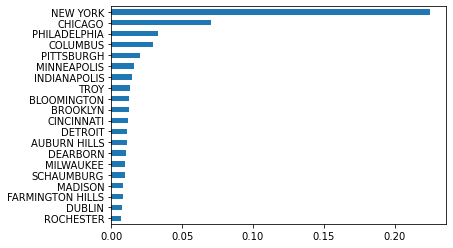

In [7]:
#Transformaremos el worksite, que tiene varios errores de tipeo
def transform1t():
    print('modificando y corrigiendo')
    try:
        Df=pd.read_sql('SELECT * FROM stging_workplace', engine) #conectamos a la nueva tabla
        print('conectado a la tabla')
    except:
        print('no se pudo conectar')
    try:
        print(Df.head())   #vemos un head de la nueva tabla
        print('Duplicados total')
        print(Df.duplicated().sum() ) #vemos la cantidad de duplicados
        print('Duplicados case id')
        print(Df['id'].duplicated().sum()) #duplicados especificos de worksite
        print('Duplicados worksite')
        print(Df['WORKSITE'].duplicated().sum()) #duplicados especificos de worksite
        print('conta nulos') 
        print('nulos')
        print(Df.isnull().sum()) #contamos nulos
        print(Df['WORKSITE'].value_counts()) #vemos el contenido de worksite
    except:
        print('error de esta parte')
        
    def a_mayusc(x): #Habiendo visto que varios worksite estan en minuscula, pasamos todos a mayusc. a fin de normalizar
        if type(x)==str:
            return x.upper()
        else:
            return x
    try:
        print('reemplazando valores')
        Dfw1 = Df.applymap(a_mayusc) #aplicamos applymap con la función mayusc definida
        Dfw1['WORKSITE'] = Dfw1['WORKSITE'].str.replace(',,',',') #reemplazamos worksite que esten con dos comas por una
        
        print(Dfw1.head())
        print(Dfw1['WORKSITE'].value_counts()) #vemos el contenido corregido del worksite
    except:
        print('fallo reemplazar valores')

    try:
        WORKSITES = Dfw1["WORKSITE"].str.rsplit(",", n = 1, expand = True) #dividimos estado de ciudad
        Dfw1["Rest_Name"]= WORKSITES[0] #definimos el nombre de la primera columna
        Dfw1['State_Name']= WORKSITES[1] #defnimos el de la segunda
        print('repartiendo')
        print(Dfw1.head()) #vemos el head nuevo
        print(Dfw1['State_Name'].value_counts()) #contenido de state
        print(Dfw1['Rest_Name'].value_counts()) #contenido de rest
        Dfw1['Rest_Name'].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
        plt.show()
        Dfw1['State_Name'].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
        plt.show()  
    except:
        print ('fallo div')
    try:
        engine.execute("DROP TABLE IF EXISTS idt_wksc;")
        Dfw1.info()
        Dfw1.drop_duplicates(Dfw1.columns[[0]], inplace = True)
        print('eliminados dup 0')
        Dfw1.info()
        Dfw1.to_sql("idt_wksc",con=engine, if_exists = 'append', chunksize = 10000,index=False)
        print ('Carga terminada Dfw1 -OK')
    except:
        print ('Hubo un error en la carga')
        
    try:
        Dfw1.info()
        Dfw1.drop_duplicates(Dfw1.columns[[5]], inplace = True)
        print('eliminados dup 5')
        Dfw1.info()
    except:
        print('error en eliminar duplicados')
        
    try:
        engine.execute("DROP TABLE IF EXISTS t_wksc;")
        Dfw1.to_sql("t_wksc",con=engine, if_exists = 'append', chunksize = 10000,index=False)
        print ('Carga terminada Dfw1mod -OK')
    except:
        print ('Hubo un error en la carga')
        


if __name__ == "__main__":
        transform1t()
        
        


In [8]:
#Buscamos un db de ciudades de US.
datosus=pd.read_csv("C:/Users/fedee/Downloads/US/US.txt", sep='\t',encoding='cp1252', index_col=None)

datosus.info()

#datosus.columns=['Country_code','Postal_code', 'Place_name', 'State_name', 'State_code', 'Country_name', 'Country_code', 'Comunity_name', 'Comunity_code', 'Lat', 'Long']

datosus.drop(datosus.columns[[0, 1, 6, 7, 8, 9, 10, 11]], axis=1, inplace= True)

datosus.info()

datosus.columns=['Place_name', 'State_name', 'State_code', 'Country_name']

datosus['Place_name'] = datosus['Place_name'].astype('str')

datosus.reset_index()

#datosus[0].astype(basestring)

datosus.info()
    
try:
    datosus.drop_duplicates(datosus.columns[[0]], inplace = True)
except:
    print('error en eliminar duplicados')
    
def a_mayusc(x): #Habiendo visto que varios us cities estan en minuscula, pasamos todos a mayusc. a fin de normalizar
        if type(x)==str:
            return x.upper()
        else:
            return x

Dfdatosus = datosus.applymap(a_mayusc)


try:
    engine.execute("DROP TABLE IF EXISTS tabla_US;")
    Dfdatosus.to_sql("tabla_US",con=engine, if_exists = 'append', chunksize = 10000,index=False)
    print ('Carga terminada OK')
except:
    print ('Hubo un error en la carga')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41482 entries, 0 to 41481
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   US              41482 non-null  object 
 1   99553           41482 non-null  int64  
 2   Akutan          41482 non-null  object 
 3   Alaska          40969 non-null  object 
 4   AK              40971 non-null  object 
 5   Aleutians East  40971 non-null  object 
 6   013             40971 non-null  float64
 7   Unnamed: 7      1 non-null      object 
 8   Unnamed: 8      1 non-null      float64
 9   54.143          41482 non-null  float64
 10  -165.7854       41482 non-null  float64
 11  1               40950 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41482 entries, 0 to 41481
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0 

C:\Users\fedee\anaconda3\lib\site-packages\pandas\io\sql.py:1444: UserWarning: The provided table name 'tabla_US' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


In [8]:
#viendo que hay varios lugares analizamos la comparación de ciudades vs. un database de ciudades de eeuu.
from difflib import SequenceMatcher

dfbase = pd.read_sql('SELECT Rest_Name FROM t_wksc', engine) #conectamos a la nueva tabla trabajada de ciudades
dfref = pd.read_sql('SELECT Place_name FROM tabla_US', engine) #conectamos a la tabla de ref

print(dfbase.value_counts())
print(dfref.value_counts())

data_dict = {"Rest_Name":[],"Place_name":[],"ratio":[]}
for x in dfbase:
    for y in dfref:
        ratio = SequenceMatcher(None, y, x).ratio() 
        data_dict["Rest_Name"].append(x)
        data_dict["Place_name"].append(y)
        data_dict["ratio"].append(ratio)
        
df_ratio = pd.DataFrame(data_dict)
print(df_ratio)

Rest_Name             
# 19820 DETROIT MI MSA    1
ONALASKA                  1
ONTARIO                   1
ONSTED                    1
ONEONTA                   1
                         ..
FRACKVILLE                1
FRANKENMUTH               1
FRANKFORT                 1
FRANKLIN                  1
ZIONSVILLE                1
Length: 4359, dtype: int64
Place_name
AARONSBURG    1
OUTLOOK       1
OTTAWA        1
OTSEGO        1
OTOE          1
             ..
GIVEN         1
GIRVIN        1
GIRDWOOD      1
GIRDLETREE    1
ZWOLLE        1
Length: 18579, dtype: int64
   Rest_Name  Place_name     ratio
0  Rest_Name  Place_name  0.526316


In [9]:
#Empresa/Rubro/Posicion/Jornada
#traemos datos de la tabla parra trabajarlos
Dferpj=pd.read_sql('SELECT * FROM tabla_test', engine)
#creamos valor llave para identificar unicos
Dferpj['Kerpj'] = Dferpj['EMPLOYER_NAME'].astype(str)+'_'+Dferpj['SOC_NAME'].astype(str)+'_'+Dferpj['JOB_TITLE'].astype(str)+'_'+Dferpj['FULL_TIME_POSITION'].astype(str)
print(Dferpj.head())
Dferpj.info()

#eliminamos duplicados, dejamos valores unicos (combinaciones)
df_erjp = Dferpj.drop_duplicates(subset = "Kerpj")
df_erjp.info()
#creamos una columna que sea llave entre ambas bases
df_erjp['idk']=df_erjp.index
print(df_erjp.head())
df_erjp['idk'] = df_erjp['idk'].astype('str')


#vinculamos el valor llave y traemos la llave a la base principal
Dferpj.insert(2, 'idk', Dferpj['Kerpj'].map(df_erjp.set_index('Kerpj')['idk']))
print(Dferpj.head())

#guardamos las tablas nuevas trabajadas
try:
    engine.execute("DROP TABLE IF EXISTS stging_soc;")
    df_erjp.to_sql("stging_soc",con=engine, if_exists = 'append', chunksize = 10000,index=False)
    print ('Carga 1 terminada OK')
except:
    print ('Hubo un error en la carga')
try:
    engine.execute("DROP TABLE IF EXISTS stging_tabla_test;")
    Dferpj.to_sql("stging_tabla_test",con=engine, if_exists = 'append', chunksize = 10000,index=False)
    print ('Carga 2 terminada OK')
except:
    print ('Hubo un error en la carga')


          CASE_NUMBER          CASE_STATUS  \
0  I-200-09285-514415            CERTIFIED   
1  I-200-09341-564186  CERTIFIED-WITHDRAWN   
2  I-200-09342-274341            CERTIFIED   
3  I-200-09364-425868            CERTIFIED   
4  I-200-10006-413683            WITHDRAWN   

                          EMPLOYER_NAME  \
0                           IT CATS LLC   
1              XPERT TECHNOLOGIES, INC.   
2                    ISR INFO WAY, INC.   
3  MAGIC CIRCLE FILMS INTERNATIONAL LLC   
4                 SAPHIRE SOLUTIONS INC   

                                      SOC_NAME SOC_CODE  \
0                    COMPUTER SYSTEMS ANALYSTS  15-1121   
1             COMPUTER OCCUPATIONS, ALL OTHER*  15-1799   
2            SOFTWARE DEVELOPERS, APPLICATIONS  15-1132   
3                       FILM AND VIDEO EDITORS  27-4032   
4  NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS  15-1142   

                   JOB_TITLE FULL_TIME_POSITION  PREVAILING_WAGE  \
0    SENIOR BUSINESS ANALYST             

<ipython-input-9-001eadc1d855>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_erjp['idk']=df_erjp.index
<ipython-input-9-001eadc1d855>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_erjp['idk'] = df_erjp['idk'].astype('str')


          CASE_NUMBER          CASE_STATUS idk  \
0  I-200-09285-514415            CERTIFIED   0   
1  I-200-09341-564186  CERTIFIED-WITHDRAWN   1   
2  I-200-09342-274341            CERTIFIED   2   
3  I-200-09364-425868            CERTIFIED   3   
4  I-200-10006-413683            WITHDRAWN   4   

                          EMPLOYER_NAME  \
0                           IT CATS LLC   
1              XPERT TECHNOLOGIES, INC.   
2                    ISR INFO WAY, INC.   
3  MAGIC CIRCLE FILMS INTERNATIONAL LLC   
4                 SAPHIRE SOLUTIONS INC   

                                      SOC_NAME SOC_CODE  \
0                    COMPUTER SYSTEMS ANALYSTS  15-1121   
1             COMPUTER OCCUPATIONS, ALL OTHER*  15-1799   
2            SOFTWARE DEVELOPERS, APPLICATIONS  15-1132   
3                       FILM AND VIDEO EDITORS  27-4032   
4  NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS  15-1142   

                   JOB_TITLE FULL_TIME_POSITION  PREVAILING_WAGE  \
0    SENIOR BUSIN

cargando
conectando a la base
conectado a la base
17770
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857216 entries, 0 to 857215
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CASE_NUMBER      857216 non-null  object 
 1   PREVAILING_WAGE  857212 non-null  float64
 2   YEAR             857216 non-null  int64  
 3   idk              857216 non-null  object 
 4   CASE_STATUS      857216 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 32.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839446 entries, 0 to 857215
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CASE_NUMBER      839446 non-null  object 
 1   PREVAILING_WAGE  839442 non-null  float64
 2   YEAR             839446 non-null  int64  
 3   idk              839446 non-null  object 
 4   CASE_STATUS      839446 non-null  object 
dty

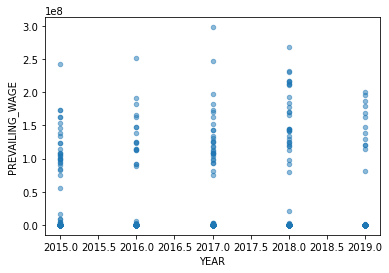

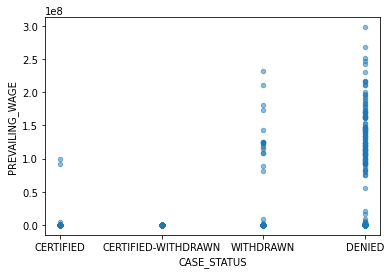

In [30]:
#Analisis sueldo y base
import seaborn as sns
print('cargando')
try:
    print('conectando a la base')
    Dfpw=pd.read_sql('SELECT CASE_NUMBER, PREVAILING_WAGE, YEAR, idk, CASE_STATUS FROM stging_tabla_test', engine)
    print('conectado a la base')
except:
    print('la base no se conecto')
    
#duplicados de case
print(Dfpw['CASE_NUMBER'].duplicated().sum())
Dfpw.info()
try:
    Dfpw.drop_duplicates(Dfpw.columns[[0]], inplace = True)
except:
    print('error en eliminar duplicados')
Dfpw.info()
    
print(Dfpw['YEAR'].value_counts())
print(Dfpw['PREVAILING_WAGE'].value_counts())

#Dfpw['PREVAILING_WAGE'].describe()
#sns.distplot(Dfpw['PREVAILING_WAGE'])

#sns.jointplot(x='PREVAILING_WAGE', y='YEAR', data=Dfpw)

#variación en años
var = 'YEAR'
data = pd.concat([Dfpw['PREVAILING_WAGE'], Dfpw[var]], axis=1)
data.plot.scatter(x=var, y='PREVAILING_WAGE', alpha = 0.5);



#variación en estado
var = 'CASE_STATUS'
data = pd.concat([Dfpw['PREVAILING_WAGE'], Dfpw[var]], axis=1)
data.plot.scatter(x=var, y='PREVAILING_WAGE', alpha = 0.5);

try:
    engine.execute("DROP TABLE IF EXISTS stg_baseid;")
    Dfpw.to_sql("stg_baseid",con=engine, if_exists = 'append', chunksize = 10000,index=False)
    print ('Carga terminada OK')
except:
    print ('Hubo un error en la carga')

#from seaborn import lmplot

#lmplot('PREVAILING_WAGE', 'WORKSITE', data=Dfpw)

#from seaborn import boxplot
#boxplot(Dfpw.PREVAILING_WAGE)

In [10]:
#Creamos esquema del DW
BBDD2 = 'dw_visa'

engine2 = create_engine(f'mysql+mysqlconnector://{USER}:{PASS}@{SERVER}/{BBDD2}', echo=False)


if __name__ == '__main__':
    engine2.execute("USE dw_visa;")
    engine2.execute("SET FOREIGN_KEY_CHECKS = 0;")

    ## Rel - id - worksite
    engine2.execute("DROP TABLE IF EXISTS dw_rel1;")
    engine2.execute("""CREATE TABLE dw_rel1(c_id VARCHAR(50), Rest_Name VARCHAR(50),
    PRIMARY KEY(c_id));""")
    ## Dimension WORKSITE
    engine2.execute("DROP TABLE IF EXISTS dw_worksite;")
    engine2.execute("""CREATE TABLE dw_worksite(Rest_Name VARCHAR(50),
    State_Name VARCHAR(50),
    WORKSITE_STATE_ABB VARCHAR(50),
    WORKSITE VARCHAR(50),
    PRIMARY KEY(Rest_Name));""")
    ## Dimension SOCIEDAD/Empleo
    engine2.execute("DROP TABLE IF EXISTS dw_soc;")
    engine2.execute("""CREATE TABLE dw_soc(soc_code VARCHAR(50),
    soc_name VARCHAR(255),
    soc_rub VARCHAR(255),
    puesto VARCHAR(255),
    jornada VARCHAR(50),
    PRIMARY KEY(soc_code));""")
    ##Proced union
    engine2.execute("DROP TABLE IF EXISTS dw_proc;")
    engine2.execute("""CREATE TABLE dw_proc(case_id VARCHAR(50),
    estado VARCHAR(50),
    year VARCHAR(50),
    empresa_code VARCHAR(50),
    sueldo INT,
    PRIMARY KEY(case_id),
    FOREIGN KEY(case_id) REFERENCES dw_rel1(c_id),
    FOREIGN KEY(empresa_code) REFERENCES dw_soc(soc_code));""")
    
    
    engine2.execute("SET FOREIGN_KEY_CHECKS = 1;")
    



In [11]:
#CARGAMOS DW 1
if __name__ == '__main__':
    engine2.execute("USE dw_visa;")
    engine2.execute("""INSERT INTO dw_worksite(Rest_Name, State_Name, WORKSITE_STATE_ABB, WORKSITE) SELECT Rest_Name, State_Name, WORKSITE_STATE_ABB, WORKSITE FROM stg_visa.t_wksc;""")
    engine2.execute("""INSERT INTO dw_rel1(c_id, Rest_Name) SELECT id, Rest_Name FROM stg_visa.idt_wksc;""")


In [12]:
#CARGAMOS DW 2
if __name__ == '__main__':
    engine2.execute("""INSERT INTO dw_soc(soc_code, soc_name, soc_rub, puesto, jornada) SELECT idk, EMPLOYER_NAME, SOC_NAME, JOB_TITLE, FULL_TIME_POSITION FROM stg_visa.stging_soc;""")

In [13]:
#CARGAMOS DW 3
if __name__ == '__main__':
    engine2.execute("""INSERT INTO dw_proc(case_id, estado, year, empresa_code, sueldo) SELECT CASE_NUMBER, CASE_STATUS, YEAR, idk, PREVAILING_WAGE FROM stg_visa.stg_baseid;""")
